# REINFORCE with baseline

## 1. 滑动平均 Baseline

在策略梯度方法中，REINFORCE 算法的目标是通过最大化累积回报来学习最优策略。然而，直接使用累积回报来更新策略参数会导致较大的方差，使得梯度估计不稳定。为了减少这种方差，可以引入 **baseline**。Baseline 是一个常数或函数，它并不影响策略梯度的期望，但可以降低其方差。

**滑动平均 Baseline** 是一种简单的技术，它使用过去回合中回报的滑动平均值作为 baseline。这样可以衡量当前回合的回报与历史回报的差异，从而减少梯度估计的方差。滑动平均基线的更新公式为：

$$ \text{baseline} = \alpha \cdot \text{baseline} + (1 - \alpha) \cdot \bar{U} $$

其中，$\alpha$ 是滑动平均的衰减因子，通常设为 0.9 或 0.99，$\bar{U}$ 是当前回合的平均回报。

### 1.1. 训练流程

1. **初始化 Baseline**：将 baseline 初始化为 0 或某个常数值。
2. **收集轨迹**：在环境中执行一回合，收集状态、动作和奖励。
3. **计算折扣回报**：根据奖励计算每个时间步的折扣回报：
   
   $$ U_t = \sum_{k=t}^n \gamma^{k-t} \cdot r_k $$

4. **更新 Baseline**：使用折扣回报的均值更新 baseline：

   $$ \text{baseline} = \alpha \cdot \text{baseline} + (1 - \alpha) \cdot \bar{U} $$

5. **计算策略梯度**：计算策略梯度时，使用 $(U_t - \text{baseline})$ 作为奖励，减去基线：

   $$ g(s_t, a_t) = (U_t - \text{baseline}) \cdot \frac{\partial \ln \pi(a_t \mid s_t)}{\partial \theta} $$

6. **更新策略参数**：根据策略梯度更新策略网络的参数。

### 1.2. 优点

- **减少方差**：通过减去基线，减少回报中的噪声，进而减少策略梯度的方差。
- **提高稳定性**：滑动平均使得策略网络的更新更加稳定。
- **无需额外网络**：滑动平均 baseline 不需要引入额外的价值网络，简单易实现。

In [1]:
# 导入库
import os
import gym
import argparse
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter

In [2]:
# 定义策略网络
class PolicyNet(nn.Module):
    def __init__(self, state_size, num_actions):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_actions)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        prob = F.softmax(x, dim=-1)
        return prob

In [3]:
# 定义REINFORCE类
class REINFORCE:
    def __init__(self, state_size, num_actions, discount, baseline_decay, device):
        self.discount = discount
        self.baseline_decay = baseline_decay
        self.device = device
        self.baseline = 0.
        self.pi = PolicyNet(state_size, num_actions).to(device)
        
    def get_action(self, state):
        # state: (state_size,)
        # prob: (num_actions)
        prob = self.pi(state)
        m = Categorical(prob)
        action = m.sample()
        log_prob = m.log_prob(action)
        return action.item(), log_prob
    
    def compute_policy_loss(self, blogp, br):
        # blogp, br: (batch_size,)
        R = 0
        ut = []
        for r in reversed(br):
            R = self.discount * R + r
            ut.insert(0, R)
        # ut: (batch_size,)
        bu = torch.tensor(ut, device=self.device)
        
        self.baseline = self.baseline_decay * self.baseline + (1 - self.baseline_decay) * bu.mean().item()
        advantage = bu - self.baseline
        policy_loss = -torch.mean(blogp * advantage)
        return policy_loss

In [4]:
# 定义Rollout类
class Rollout:
    def __init__(self, device):
        self.device = device
        self.bs = []
        self.ba = []
        self.blogp = []
        self.br = []
        self.bd = []
        self.bns = []
    
    def push(self, state, action, logp, reward, done, next_state):
        self.bs.append(state)
        self.ba.append(action)
        self.blogp.append(logp)
        self.br.append(reward)
        self.bd.append(done)
        self.bns.append(next_state)
        
    def tensor(self):
        bs = torch.as_tensor(self.bs, dtype=torch.float32, device=self.device)
        ba = torch.as_tensor(self.ba, dtype=torch.long, device=self.device)  
        blogp = torch.stack(self.blogp).to(self.device)  
        br = torch.as_tensor(self.br, dtype=torch.float32, device=self.device)
        bd = torch.as_tensor(self.bd, dtype=torch.float32, device=self.device)
        bns = torch.as_tensor(self.bns, dtype=torch.float32, device=self.device)
        return bs, ba, blogp, br, bd, bns
    
    def clear(self):
        self.bs = []
        self.ba = []
        self.blogp = []
        self.br = []
        self.bd = []
        self.bns = []

In [5]:
# 训练
def train(args, env):
    agent = REINFORCE(args.state_size, args.num_actions, args.discount, args.baseline_decay, args.device)
    rollout = Rollout(args.device)
    pi_optimizer = torch.optim.Adam(agent.pi.parameters(), lr=args.lr)
    writer = SummaryWriter()
    save_path = os.path.join(args.output_dir, 'model.bin')
    
    episode_reward = 0
    episode_length = 0
    episode_num = 0
    max_episode_reward = float('-inf')
    
    agent.pi.train()
    state, _ = env.reset()
    
    for i in range(args.max_steps):
        action, log_prob = agent.get_action(torch.tensor(state, dtype=torch.float32, device=args.device))
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        rollout.push(state, action, log_prob, reward, done, next_state)
        episode_reward += reward
        episode_length += 1
        state = next_state
        
        if done:
            bs, ba, blogp, br, bd, bns = rollout.tensor()
            policy_loss = agent.compute_policy_loss(blogp, br)
            pi_optimizer.zero_grad()
            policy_loss.backward()
            pi_optimizer.step()
            
            if episode_reward >= max_episode_reward:
                max_episode_reward = episode_reward
                torch.save(agent.pi.state_dict(), save_path)
                
            writer.add_scalar('Maximum reward', max_episode_reward, episode_num)
            writer.add_scalar('Episode reward', episode_reward, episode_num)
            writer.add_scalar('Episode length', episode_length, episode_num)
            print(f'step = {i}, reward = {episode_reward:.0f}, length = {episode_length}, max reward = {max_episode_reward}')
            
            episode_reward = 0
            episode_length = 0
            episode_num += 1
            state, _ = env.reset()
            rollout.clear()
            
    writer.close()

In [6]:
# 测试
def eval(args, env):
    agent = REINFORCE(args.state_size, args.num_actions, args.discount, args.baseline_decay, args.device)
    model_path = os.path.join(args.output_dir, 'model.bin')
    agent.pi.load_state_dict(torch.load(model_path))
    agent.pi.to(args.device)
    agent.pi.eval()
    
    episode_reward = 0
    episode_length = 0
    state, _ = env.reset()
    for _ in range(5000):
        action, _ = agent.get_action(torch.tensor(state, dtype=torch.float32, device=args.device))
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        episode_length += 1
        state = next_state
        
        if done:
            state, _ = env.reset()
            print(f'episode reward = {episode_reward:.0f}, episode length = {episode_length}')
            episode_reward = 0
            episode_length = 0

In [7]:
# 运行
args = argparse.Namespace()
args.env = 'CartPole-v1'
args.state_size = 4
args.num_actions = 2
args.discount = 0.99
args.baseline_decay = 0.99
args.max_steps = int(2e5)
args.lr = 3e-3
args.output_dir = 'output'
if torch.cuda.is_available():
    args.device = torch.device('cuda')
else:
    args.device = torch.device('cpu')
    
os.makedirs(args.output_dir, exist_ok=True)
    
env = gym.make(args.env)
env.reset(seed=42)
env.action_space.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if args.device == torch.device('cuda'):
    torch.cuda.manual_seed(42)
print('Training started...')
train(args, env)
print('Training completed!')

print('Evaluation started...')
eval(args, env)
print('Evaluation completed!')

Training started...
step = 15, reward = 16, length = 16, max reward = 16.0
step = 37, reward = 22, length = 22, max reward = 22.0
step = 55, reward = 18, length = 18, max reward = 22.0
step = 82, reward = 27, length = 27, max reward = 27.0
step = 96, reward = 14, length = 14, max reward = 27.0
step = 111, reward = 15, length = 15, max reward = 27.0
step = 138, reward = 27, length = 27, max reward = 27.0
step = 170, reward = 32, length = 32, max reward = 32.0
step = 194, reward = 24, length = 24, max reward = 32.0
step = 245, reward = 51, length = 51, max reward = 51.0
step = 272, reward = 27, length = 27, max reward = 51.0
step = 283, reward = 11, length = 11, max reward = 51.0
step = 311, reward = 28, length = 28, max reward = 51.0
step = 330, reward = 19, length = 19, max reward = 51.0
step = 367, reward = 37, length = 37, max reward = 51.0
step = 379, reward = 12, length = 12, max reward = 51.0
step = 398, reward = 19, length = 19, max reward = 51.0
step = 411, reward = 13, length =

/Users/xavier/PythonCode/venv/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)


step = 536, reward = 22, length = 22, max reward = 51.0
step = 549, reward = 13, length = 13, max reward = 51.0
step = 625, reward = 76, length = 76, max reward = 76.0
step = 643, reward = 18, length = 18, max reward = 76.0
step = 661, reward = 18, length = 18, max reward = 76.0
step = 697, reward = 36, length = 36, max reward = 76.0
step = 711, reward = 14, length = 14, max reward = 76.0
step = 731, reward = 20, length = 20, max reward = 76.0
step = 771, reward = 40, length = 40, max reward = 76.0
step = 802, reward = 31, length = 31, max reward = 76.0
step = 828, reward = 26, length = 26, max reward = 76.0
step = 855, reward = 27, length = 27, max reward = 76.0
step = 894, reward = 39, length = 39, max reward = 76.0
step = 907, reward = 13, length = 13, max reward = 76.0
step = 916, reward = 9, length = 9, max reward = 76.0
step = 939, reward = 23, length = 23, max reward = 76.0
step = 956, reward = 17, length = 17, max reward = 76.0
step = 1016, reward = 60, length = 60, max reward 

step = 17819, reward = 248, length = 248, max reward = 500.0
step = 18062, reward = 243, length = 243, max reward = 500.0
step = 18190, reward = 128, length = 128, max reward = 500.0
step = 18440, reward = 250, length = 250, max reward = 500.0
step = 18609, reward = 169, length = 169, max reward = 500.0
step = 18780, reward = 171, length = 171, max reward = 500.0
step = 18924, reward = 144, length = 144, max reward = 500.0
step = 19062, reward = 138, length = 138, max reward = 500.0
step = 19215, reward = 153, length = 153, max reward = 500.0
step = 19278, reward = 63, length = 63, max reward = 500.0
step = 19404, reward = 126, length = 126, max reward = 500.0
step = 19543, reward = 139, length = 139, max reward = 500.0
step = 19613, reward = 70, length = 70, max reward = 500.0
step = 19725, reward = 112, length = 112, max reward = 500.0
step = 19834, reward = 109, length = 109, max reward = 500.0
step = 19954, reward = 120, length = 120, max reward = 500.0
step = 20098, reward = 144, 

step = 38171, reward = 180, length = 180, max reward = 500.0
step = 38357, reward = 186, length = 186, max reward = 500.0
step = 38537, reward = 180, length = 180, max reward = 500.0
step = 38726, reward = 189, length = 189, max reward = 500.0
step = 38923, reward = 197, length = 197, max reward = 500.0
step = 39219, reward = 296, length = 296, max reward = 500.0
step = 39529, reward = 310, length = 310, max reward = 500.0
step = 39761, reward = 232, length = 232, max reward = 500.0
step = 39995, reward = 234, length = 234, max reward = 500.0
step = 40215, reward = 220, length = 220, max reward = 500.0
step = 40641, reward = 426, length = 426, max reward = 500.0
step = 40915, reward = 274, length = 274, max reward = 500.0
step = 41145, reward = 230, length = 230, max reward = 500.0
step = 41645, reward = 500, length = 500, max reward = 500.0
step = 41843, reward = 198, length = 198, max reward = 500.0
step = 42056, reward = 213, length = 213, max reward = 500.0
step = 42333, reward = 2

step = 73020, reward = 249, length = 249, max reward = 500.0
step = 73388, reward = 368, length = 368, max reward = 500.0
step = 73777, reward = 389, length = 389, max reward = 500.0
step = 73990, reward = 213, length = 213, max reward = 500.0
step = 74357, reward = 367, length = 367, max reward = 500.0
step = 74834, reward = 477, length = 477, max reward = 500.0
step = 75193, reward = 359, length = 359, max reward = 500.0
step = 75693, reward = 500, length = 500, max reward = 500.0
step = 76095, reward = 402, length = 402, max reward = 500.0
step = 76327, reward = 232, length = 232, max reward = 500.0
step = 76610, reward = 283, length = 283, max reward = 500.0
step = 77017, reward = 407, length = 407, max reward = 500.0
step = 77497, reward = 480, length = 480, max reward = 500.0
step = 77946, reward = 449, length = 449, max reward = 500.0
step = 78388, reward = 442, length = 442, max reward = 500.0
step = 78693, reward = 305, length = 305, max reward = 500.0
step = 79012, reward = 3

step = 113961, reward = 109, length = 109, max reward = 500.0
step = 114060, reward = 99, length = 99, max reward = 500.0
step = 114186, reward = 126, length = 126, max reward = 500.0
step = 114298, reward = 112, length = 112, max reward = 500.0
step = 114427, reward = 129, length = 129, max reward = 500.0
step = 114535, reward = 108, length = 108, max reward = 500.0
step = 114689, reward = 154, length = 154, max reward = 500.0
step = 114781, reward = 92, length = 92, max reward = 500.0
step = 114901, reward = 120, length = 120, max reward = 500.0
step = 115005, reward = 104, length = 104, max reward = 500.0
step = 115114, reward = 109, length = 109, max reward = 500.0
step = 115247, reward = 133, length = 133, max reward = 500.0
step = 115365, reward = 118, length = 118, max reward = 500.0
step = 115514, reward = 149, length = 149, max reward = 500.0
step = 115631, reward = 117, length = 117, max reward = 500.0
step = 115777, reward = 146, length = 146, max reward = 500.0
step = 11594

step = 162484, reward = 500, length = 500, max reward = 500.0
step = 162984, reward = 500, length = 500, max reward = 500.0
step = 163457, reward = 473, length = 473, max reward = 500.0
step = 163916, reward = 459, length = 459, max reward = 500.0
step = 164416, reward = 500, length = 500, max reward = 500.0
step = 164851, reward = 435, length = 435, max reward = 500.0
step = 165333, reward = 482, length = 482, max reward = 500.0
step = 165833, reward = 500, length = 500, max reward = 500.0
step = 166333, reward = 500, length = 500, max reward = 500.0
step = 166814, reward = 481, length = 481, max reward = 500.0
step = 167284, reward = 470, length = 470, max reward = 500.0
step = 167778, reward = 494, length = 494, max reward = 500.0
step = 168278, reward = 500, length = 500, max reward = 500.0
step = 168778, reward = 500, length = 500, max reward = 500.0
step = 169278, reward = 500, length = 500, max reward = 500.0
step = 169778, reward = 500, length = 500, max reward = 500.0
step = 1

#### Reward:
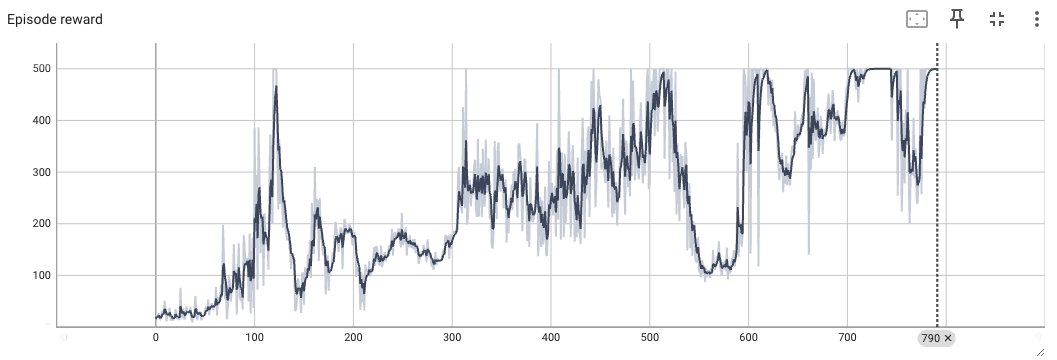

#### Maximum reward:
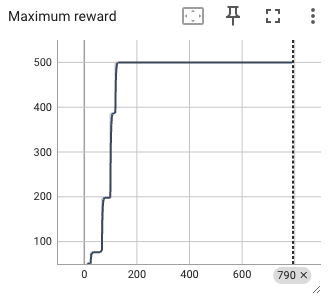